In [7]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
import pandas as pd
from sklearn.preprocessing import LabelEncoder # poderia ser LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
%matplotlib inline
plt.style.use('ggplot')

# Modelo 

In [1]:
class KNNClassifier(object):
    def __init__(self, n = 1):
        self.X_train = None
        self.y_train = None
        self.n = n

    def closest(self, row):
        """
        Retorna a classe respondente ao ponto mais próximo do dataset de treino.\
        É um exemplo de implementação do kNN com k=1.
        """
    
        # calcula as distâncias(norma L2) entre row e os pontos no dataset
        distances = np.linalg.norm(self.X_train - row, axis=1)
        # calcula os índices dos n pontos com menor distância para row
        smallest_n_ix = np.argpartition(distances, self.n)[:self.n]
        # calcula os labels dos pontos do passo anterior
        labels = self.y_train[smallest_n_ix]
        
        # retorna o label com a maior quantidade de ocorrências em labels
        return np.bincount(labels).argmax()

    def fit(self, training_data, training_labels):
        self.X_train = training_data
        self.y_train = training_labels
        
        return self

    def predict(self, to_classify):
        predictions = []
        for row in to_classify:
            label = self.closest(row)
            predictions.append(label)
        return predictions

# Titanic Dataset

In [5]:
df = pd.read_csv("https://github.com/abevieiramota/kaggle-titanic/raw/master/data/train.csv")

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [17]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [61]:
# converte valores categóricos em inteiros com range [0, n_categorias - 1]
sex_encoder = LabelEncoder().fit(df.Sex)
df['Sex_encoded'] = sex_encoder.transform(df.Sex)

cabin_encoder = LabelEncoder().fit(df.Cabin.fillna("None"))
# atribui None aos valores faltantes em Cabin
df["Cabin_encoded"] = cabin_encoder.transform(df.Cabin.fillna("None"))

embarked_encoder = LabelEncoder().fit(df.Embarked.fillna("None"))
# atribui None aos valores faltantes em Embarked
df["Embarked_encoded"] = embarked_encoder.transform(df.Embarked.fillna("None"))

# atribui a média de Age aos valores faltantes em Age
df['Age_imputed'] = df.Age.fillna(df.Age.mean())

In [62]:
# colunas selecionadas para treino
columns = ['Pclass', 'Sex_encoded', 'Cabin_encoded', 'Embarked_encoded', 'Age_imputed', 'SibSp', 'Parch']

In [63]:
df[columns].corr()

,Pclass,Sex_encoded,Cabin_encoded,Embarked_encoded,Age_imputed,SibSp,Parch
Pclass,1.000000,0.131900,0.682176,0.197493,-0.331339,0.083081,0.018443
Sex_encoded,0.131900,1.000000,0.095991,0.106395,0.084153,-0.114631,-0.245489
Cabin_encoded,0.682176,0.095991,1.000000,0.232192,-0.234912,0.043525,-0.028179
Embarked_encoded,0.197493,0.106395,0.232192,1.000000,-0.034883,0.068043,0.032517
Age_imputed,-0.331339,0.084153,-0.234912,-0.034883,1.000000,-0.232625,-0.179191
SibSp,0.083081,-0.114631,0.043525,0.068043,-0.232625,1.000000,0.414838
Parch,0.018443,-0.245489,-0.028179,0.032517,-0.179191,0.414838,1.000000


In [64]:
# remove Cabin_encoded, dada a alta correlação com Pclass
columns.remove('Cabin_encoded')

In [66]:
# escala linearmente as colunas para o range [0, 1] e gera o dataset a ser utilizada
#    no treinamento do modelo
X = MinMaxScaler().fit_transform(df[columns])
# gera o vetor y, com o atributo da classificação
y = df.Survived.values 

In [67]:
# particiona o dataset em
#    dataset de treino, a partir do qual o modelo será treinado
#    dataset de validação, a partir do qual o modelo treinado será avaliado
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.1, random_state=1)

In [68]:
knn = KNeighborsClassifier()
# objeto responsável por gerar uma partição(n_splits=1) aleatória
#    com 75% dos dados para treino e 25% dos dados para teste(test_size=.25)
#    fixa random_state=0 para permitir que o resultado seja reproduzido
ss = ShuffleSplit(test_size=.25, n_splits=1, random_state=0)

n_neighbors = np.arange(1, 30, 4)
param_grid = {'n_neighbors': n_neighbors}

# classe responsável por treinar o modelo com todas as combinações
#   de parâmetros em param_grid, sobre todas as partições geradas pelo ShuffleSplit
cv = GridSearchCV(knn, param_grid, cv=ss)
# executa o treinamento
cv.fit(X_train, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=0, test_size=0.25, train_size=None),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([ 1,  5,  9, 13, 17, 21, 25, 29])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

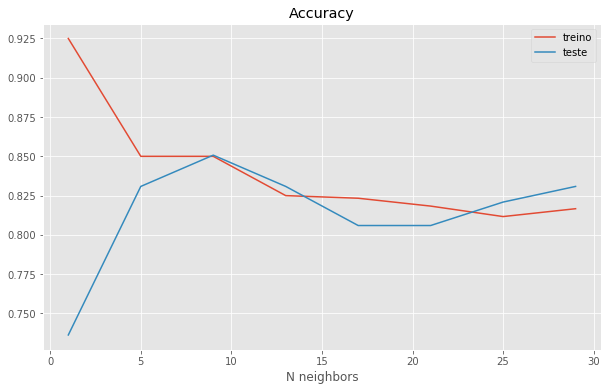

In [75]:
plt.figure(figsize=(10, 6))
plt.plot(n_neighbors, cv.cv_results_['mean_train_score'])
plt.plot(n_neighbors, cv.cv_results_['mean_test_score'])
plt.legend(['treino', 'teste'])
plt.title("Accuracy")
plt.xlabel("N neighbors")

In [78]:
cv.best_params_

{'n_neighbors': 9}

In [80]:
# seleciona o modelo com melhor accuracy sobre o dataset de teste
#    de acordo com as partições geradas pelo ShuffleSplit
best_fit = cv.best_estimator_
# treina com todo o dataset de treino
best_fit.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform')

In [81]:
# avalia seu desempenho sobre o dataset de validação(não foi utilizado no treinamento)
print(classification_report(best_fit.predict(X_valid), y_valid))

             precision    recall  f1-score   support

          0       0.87      0.72      0.79        64
          1       0.51      0.73      0.60        26

avg / total       0.77      0.72      0.73        90

